In [1]:
# Import necessary libraries
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

In [2]:
class ArmedBanditsEnv():
    """
    num_expt -> number of experiments 
    num_slots -> available slots that can transmit data based on availablility
    p_values -> num_expts x num_slots matrix containing p-values for availability of slot
    action -> num_expts x num_slots array denoting the order of checking slots for availability for each expt
    """
    
    def __init__(self, p_values):
        assert len(p_values.shape) == 2
        
        self.num_slots = p_values.shape[1]
        self.num_expts = p_values.shape[0]
        self.state = np.zeros((self.num_expts,self.num_slots))
        
        self.p_values = p_values
    
        
    def step(self, action_type, action):
        
        # Sample from the specified slot using it's bernoulli distribution
        assert (action.shape == (self.num_expts,self.num_slots))
        
        sampled_state = np.random.binomial(n=1, p=self.p_values)

        self.state = sampled_state

        cost = np.zeros((self.num_expts, 1))

        for j in range(self.num_expts):
            # Get the relevant actions and their indices for the current experiment
            if action_type[j]==0:
                cost[j]=self.num_slots
            else:
                actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
                relevant_states = sampled_state[j, actions]
                # Find the index of the first occurrence of 1, if any
                indices = np.where(relevant_states == 1)[0]
                if indices.size > 0:
                    first_one_index = indices[0]
                else:
                    first_one_index = len(actions)
                # Calculate the cost
                cost[j] = first_one_index
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return cost,self.state, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsBernoulli(ArmedBanditsEnv):
    def __init__(self, num_expts=1, num_slots=5):
        self.p_values = np.random.uniform(0, 1, (num_expts, num_slots))
        
        ArmedBanditsEnv.__init__(self, self.p_values)

In [7]:
p_values = np.array([[0.1, 0.4, 0.2, 0.3]]) # The p_values for a four-slot channel. Single experiment

env = ArmedBanditsEnv(p_values) # Create the environment

for i in range(4):
    action = np.random.choice(range(1, 5), size=(1,4), replace=False)
    cost,state, _, _ = env.step([1],action)
    print("State:",state ,"on Order:", action, " gave a cost of:",cost[0])

State: [[0 0 0 0]] on Order: [[3 2 1 4]]  gave a cost of: [4.]
State: [[1 0 0 0]] on Order: [[1 3 2 4]]  gave a cost of: [0.]
State: [[0 0 1 0]] on Order: [[4 1 2 3]]  gave a cost of: [3.]
State: [[0 0 1 0]] on Order: [[1 2 4 3]]  gave a cost of: [3.]


In [8]:
def inc_p(prev_p, new_val, n):
    return (prev_p*(n-1) + new_val)/n
inc_p_vect = np.vectorize(inc_p)


## THE GREEDY AGENT

It can be derived directly from greedy epsilon agent created later.

In [9]:
def greedy_order(estimates):
    """
    Takes in an array of estimates of num_expts x num_slots and returns the order
    of slots with the decreasing estimated p_value for each row. 
    Breaks ties randomly by introducing a small random noise.
    """
    if estimates.ndim == 1:
        sorted_indices = sort_with_noise(estimates)
    else:
        sorted_indices = np.apply_along_axis(sort_with_noise, 1, estimates)
    return sorted_indices

def sort_with_noise(row):
    # Identifying unique values and their counts
    unique, counts = np.unique(row, return_counts=True)
    
    # Only add noise to elements where there are ties
    for value, count in zip(unique, counts):
        if count > 1:
            noise = np.random.normal(0, 1e-6, count)  # Small noise
            indices = row == value
            row[indices] += noise

    # Sort the indices after adding noise
    sorted_indices = np.argsort(-row) + 1
    return sorted_indices




In [10]:
estimates_1d = np.array([0.2, 0.2, 0.07, 0.1])
print(greedy_order(estimates_1d))

estimates_2d = np.array([[0.1, 0.3, 0.05, 0.2], [0.4, 0.2, 0.1, 0.3]])
print(greedy_order(estimates_2d))

[1 2 4 3]
[[2 4 1 3]
 [1 4 2 3]]


## Epsilon-Greedy Agent

In [11]:
class EpsilonGreedyAgent():
    def __init__(self, estimates, epsilon):
        
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        assert len(estimates.shape) == 2
        
        self.num_slots = estimates.shape[1]
        self.num_expts = estimates.shape[0]
        self.estimates = estimates.astype(np.float64)
        self.action_count = np.zeros(estimates.shape)
        self.epsilon = epsilon
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_expts) > self.epsilon).astype(int).reshape(-1,1)
        
        # Generate both types of actions for every experiment
        exploratory_action = np.tile(np.arange(1, num_slots + 1), (num_expts, 1))
        greedy_action = greedy_order(self.estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        return action_type,action
    
    def update_estimates(self, cost, state, action_type, action):
        for j in range(self.num_expts):
            if action_type[j]==0:
                # Increment action_count for all slots
                self.action_count[j] += 1
        
                # Apply the vectorized inc_p function to the entire row
                n = self.action_count[j]
                self.estimates[j] = inc_p(self.estimates[j], state[j], n)
            else:

                num_expts, num_slots = action.shape

            
                c = int(cost[j][0])
                changed = action[j][:c]-1

                # Update the estimates and counts for the changed actions
                self.action_count[j, changed] += 1

                self.estimates[j, changed] = inc_p(self.estimates[j, changed], 0, self.action_count[j, changed])

                # Update the estimates and counts for the not-changed action, if it exists
                if c < num_slots:
                    self.action_count[j, c] += 1
                    self.estimates[j, c] = inc_p(self.estimates[j, c], 1, self.action_count[j, c])
            
             
        

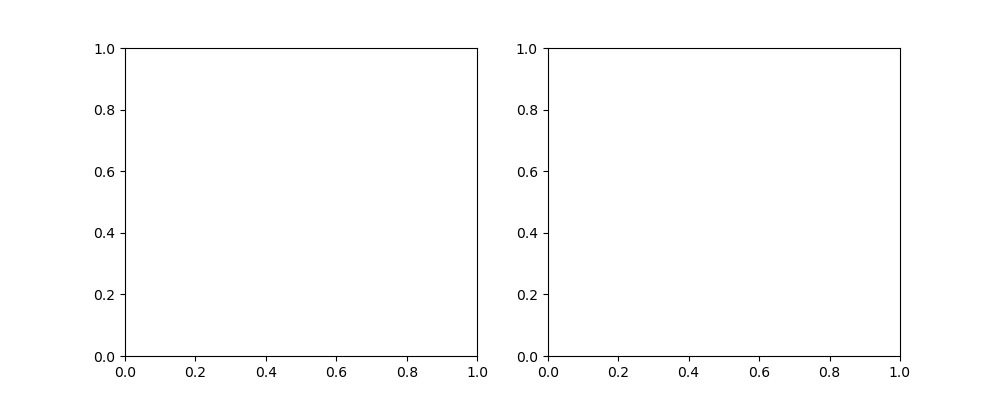

In [14]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0.1)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action = agent.get_action()
    cost,state,_,_ = env.step(action_type,action)
    agent.update_estimates(cost,state,action_type,action)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        # [Rest of the step function code]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()



Greedy agent is derived by taking epsilon as 0

c:\Users\Dell\miniconda3\envs\bandits\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


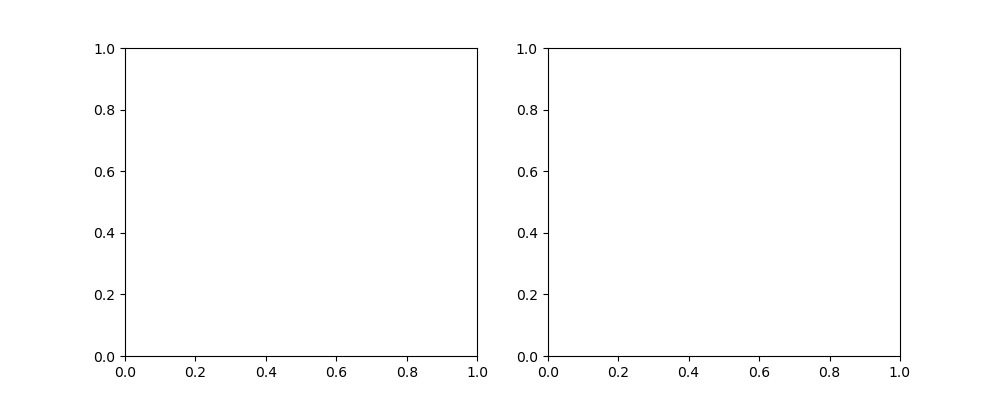

In [13]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action = agent.get_action()
    cost,state,_,_ = env.step(action_type,action)
    agent.update_estimates(cost,state,action_type,action)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        # [Rest of the step function code]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

